In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from scipy.integrate import quad
import gdown
from IPython.display import clear_output as clc

In [2]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# Mesh-Informed Neural Network

Consider for instance a parameter dependent PDE problem, where each parameter instance $\mu$ leads to a solution $u_\mu$. The goal is learning the operator $\mu \to u_\mu$.

More generally Mesh-Informed Neural Networks (MINNs), tackle the problem of learning an operator  

$$  
\mathcal{G} : V_1 \to V_2,  
$$  

where $V_1$ and $V_2$ are some functional spaces.

To cast the problem to a discrete setting, one introduces a mesh having vertices $\{x_i\}_{i=1}^{N_h} \subset \Omega$, and defines $V_h \subset L^2(\Omega)$ as the subspace of piecewise linear Lagrange polynomials, where $h > 0$ is the stepsize of the mesh (the idea can be easily generalized to higher order Finite Elements, as we show later on). Since each $v \in V_h$ is uniquely identified by its nodal values, $V_h \cong \mathbb{R}^{N_h}$, and the original operator to be learned can be replaced by  

$$  
\mathcal{G}_h : V_h \cong \mathbb{R}^{N_h} \to V_h \cong \mathbb{R}^{N_h}.  
$$  

The idea is now to approximate $\mathcal{G}_h$ by training some DNN $\Phi : \mathbb{R}^{N_h} \to \mathbb{R}^{N_h}$. Dense architectures are unsuited for such a purpose because of their prohibitive computational cost during training, which is mostly caused by: i) the computational resources required for the optimization, ii) the amount of training data needed to avoid overfitting.  

To overcome this bottleneck, [1] propose Mesh-Informed Neural Networks. These are ultimately based on an *a priori* pruning strategy, whose purpose is to inform the model with the geometrical knowledge coming from $\Omega$.


## Mesh-Informed Layers

**Definition 1** Let $m, n \geq 1$ and $\rho : \mathbb{R} \rightarrow \mathbb{R}$. A layer with activation $\rho$ is a map $L : \mathbb{R}^m \rightarrow \mathbb{R}^n$ of the form $L(\mathbf{v}) = \rho (\mathbf{W} \mathbf{v} + \mathbf{b})$, for some $\mathbf{W} \in \mathbb{R}^{n \times m}$ and $\mathbf{b} \in \mathbb{R}^n$.



where $\rho$ is evaluated over an $n$-dimensional vector: $\rho([x_1, \ldots, x_n]) := [\rho(x_1), \ldots, \rho(x_n)]$.

----


**Definition 2** Let $m, n \geq 1$. A neural network of depth $l \geq 0$ is a map $\Phi : \mathbb{R}^m \rightarrow \mathbb{R}^n$ obtained via composition of $l + 1$ layers, $\Phi = L_{l+1} \circ \ldots \circ L_1$.

-----

**Definition 3**  
Let $\Omega \subset \mathbb{R}^d$ be a bounded domain. Let $\mathcal{M}$ be a collection of $d$-simplices in $\Omega$, so that each $K \in \mathcal{M}$ is a closed subset of $\overline{\Omega}$. For each element $K \in \mathcal{M}$, define the quantities

$$
h_K := \operatorname{diam}(K), \qquad R_K := \sup \left\{ \operatorname{diam}(S) \mid S \text{ is a ball contained in } K \right\}.
$$

 $\mathcal{M}$ is an admissible mesh of stepsize $h > 0$ over $\Omega$ if the following conditions hold.

1. The elements are exhaustive, that is
$$
\text{dist} \left( \overline{\Omega}, \bigcup_{K \in \mathcal{M}} K \right) \leq h
$$
where $\text{dist}(A, B) = \sup_{x \in A} \inf_{y \in B} |x - y|$ is the distance between $A$ and $B$.

2. Any two distinct elements $K, K' \in \mathcal{M}$ have disjoint interiors. Also, their intersection is either empty or results in a common face of dimension $s < d$.

3. The elements are non-degenerate and their maximum diameter equals $h$, that is
$$
\min_{K \in \mathcal{M}} R_K > 0 \quad \text{and} \quad \max_{K \in \mathcal{M}} h_K = h.
$$

In that case, the quantity
$$
\sigma = \min_{K \in \mathcal{M}} \frac{h_K}{R_K} < +\infty,
$$
is said to be the **aspect-ratio of the mesh**.

---



**Definition 4**  
Let $\Omega \subset \mathbb{R}^d$ be a bounded domain and let $\mathcal{M}$ be a mesh of stepsize $h > 0$ defined over $\Omega$. For any positive integer $q$,  $ X_h^q(\mathcal{M})$ is the Finite Element space of piecewise polynomials of degree at most $q$, that is

$$
X_h^q(\mathcal{M}) := \{ v \in C(\overline{\Omega}) \text{ s.t. } v|_K \text{ is a polynomial of degree at most } q \quad \forall K \in \mathcal{M} \}.
$$

Let $N_h = \dim(X_h^q(\mathcal{M}))$. A collection of nodes $\{\mathbf{x}_i\}_{i=1}^{N_h} \subset \Omega$ and a sequence of functions $\{ \varphi_i \}_{i=1}^{N_h} \subset X_h^q(\mathcal{M})$ define a **Lagrangian basis** of $X_h^q(\mathcal{M})$ if

$$
\varphi_j(\mathbf{x}_i) = \delta_{i,j}, \quad i, j = 1, \ldots, N_h.
$$

 $\Pi_{h,q}(\mathcal{M}) : X_h^q(\mathcal{M}) \to \mathbb{R}^{N_h}$ is the function-to-nodes operator,
$$
\Pi_{h,q}(\mathcal{M}) : v \mapsto [v(\mathbf{x}_1), \ldots, v(\mathbf{x}_{N_h})],
$$
whose inverse is
$$
\Pi_{h,q}^{-1}(\mathcal{M}) : \mathbf{c} \mapsto \sum_{i=1}^{N_h} c_i \varphi_i.
$$

---


We now have all we need to introduce our concept of **mesh-informed layer**.

**Definition 5** (Mesh-informed layer)  
Let $\Omega \subset \mathbb{R}^d$ be a bounded domain and $d : \Omega \times \Omega \to [0, +\infty)$ a given distance function. Let $\mathcal{M}$ and $\mathcal{M}'$ be two meshes of stepsizes $h$ and $h'$, respectively. Let $V_h = X_h^q(\mathcal{M})$ and $V_{h'} = X_{h'}^q(\mathcal{M}')$ be the input and output spaces, respectively.

Denote by $\{ \mathbf{x}_j \}_{j=1}^{N_h}$ and $\{ \mathbf{x}_i' \}_{i=1}^{N_{h'}}$ the nodes associated to a Lagrangian basis of $V_h$ and $V_{h'}$ respectively.

A mesh-informed layer with activation function $\rho : \mathbb{R} \to \mathbb{R}$ and support $r > 0$ is a map $\mathcal{L} : V_h \to V_{h'}$ of the form
$$
\mathcal{L} = \Pi_{h',q}^{-1}(\mathcal{M}') \circ \tilde{L} \circ \Pi_{h,q}(\mathcal{M}),
$$
where $\tilde{L} : \mathbb{R}^{N_h} \to \mathbb{R}^{N_{h'}}$ is a layer with activation $\rho$ whose weight matrix $\mathbf{W}$ satisfies the additional sparsity constraint below,
$$
d(\mathbf{x}_j, \mathbf{x}_i') > r \Longrightarrow \mathbf{W}_{i,j} = 0.
$$  

The distance function $d$ in Definition 5 can be any metric over $\Omega$. For instance, one may choose to consider the Euclidean distance, $d(\mathbf{x}, \mathbf{x}') := \|\mathbf{x} - \mathbf{x}'\|$.   

It is worth pointing out that, as a matter of fact, the projections $\Pi_{h,q}(\mathcal{M})$ and $\Pi^{-1}_{h',q'}(\mathcal{M}')$ have the sole purpose of making Definition 3 rigorous. What actually defines the mesh-informed layer $L$ are the sparsity patterns imposed to $\tilde{L}$. The idea is that these constraints should help the layer in producing outputs that are more coherent with the underlying spatial domain, see figure below.

----


<div align="center"><img src="https://media.springernature.com/lw1200/springer-static/image/art%3A10.1007%2Fs10915-023-02331-1/MediaObjects/10915_2023_2331_Fig1_HTML.png" width="70%" height="70%"></div>
The dense model features 3 neurons at input and 5 at output. All the neurons communicate: consequently the weight matrix of the layer has 15 active entries. In the mesh-informed counterpart, neurons become vertices of two meshes (resp. in green and red) defined over the same spatial domain $\Omega$. Only nearby neurons are allowed to communicate. This results in a sparse model with only 9 active weights

Starting from here, MINNs is defined by composition, with a possible interchange of dense and mesh-informed layers. Consider for instance the case in which we want to define a Mesh-Informed Neural Network $\Phi : \mathbb{R}^p \rightarrow V_h \cong \mathbb{R}^{N_h}$ that maps a low-dimensional input, say $p \ll N_h$, to some functional output. Then, one possible architecture could be  

$$
\Phi : \mathbb{R}^p \xrightarrow{} V_{4h} \xrightarrow{r = 0.5}V_{2h}  \xrightarrow{r = 0.25}V_{h}
$$  

(1)  

The above scheme defines a MINN of depth $l = 2$, as it is composed of 3 layers. The first layer is dense (Definition 1) and has the purpose of preprocessing the input while mapping the data onto a coarse mesh (stepsize $4h$). Then, the remaining two layers perform local transformations in order to return the desired output.

### Intuition
Dense layers treat inputs/outputs as unstructured vectors, disregarding the underlying spatial relationships.
Instead, physical phenomena (e.g., diffusion, advection) often involve local interactions: the value of a PDE solution at a point $x$ is typically influenced by nearby points, not distant ones  (e.g., nearby nodes in a mesh are physically correlated).
  
Moreover, nonlocal effects (e.g., integral operators) can still be handled by combining local layers with occasional dense layers at coarser resolutions.  

The sparsity constraint enforces this locality by allowing neurons (mesh nodes) to communicate only if they are geometrically close in the domain
$\Omega$,

## Implementation Details

For simplicity, focus on the case in which distances are evaluated according to the Euclidean metric, $d(\mathbf{x}, \mathbf{x}') = |\mathbf{x} - \mathbf{x}'|$. Given $\Omega \subset \mathbb{R}^d$, $h, h' > 0$, let $X \in \mathbb{R}^{N_h \times d}$ and $X' \in \mathbb{R}^{N_{h'} \times d}$ be the matrices containing the degrees of freedom associated to the chosen Finite Element spaces, that is $X_j := [X_{j,1}, \ldots, X_{j,d}]$ are the coordinates of the $j$th node in the input mesh, and similarly for $X'$. In order to build a mesh-informed layer of support $r > 0$, we first compute all the pairwise distances $D_{i,j} := |X_{j,.} - X_{i,.}'|^2$ among the nodes in the two meshes. This can be done efficiently using tensor algebra, e.g.

$$
D = \sum_{l=1}^d (e_{N_{h'}} \otimes X_{.,l} - X_{.,l}^{'} \otimes e_{N_h})^{\circ 2}
$$

where $X_{.,l}$ is the $l$th column of $X$, $e_k := [1, \ldots, 1] \in \mathbb{R}^k$, $\otimes$ is the tensor product and $\circ 2$ is the Hadamard power. We then extract the indices $\{(i_k, j_k)\}_{k=1}^{\text{dof}}$ for which $D_{i_k, j_k} \leq r^2$ and initialize a weight vector $w \in \mathbb{R}^{\text{dof}}$. This allows us to declare the weight matrix $W$ in sparse format by letting the nonzero entries be equal to $w_k$ at position $(i_k, j_k)$, so that $||W||_0 = \text{dof}$. Preliminary to the training phase, we fill the entries of $w$ with random values sampled from a suitable Gaussian distribution.

## Training
Let $\mathcal{G}_h : \Theta \rightarrow V_h$ be the high-fidelity discretization of a suitable operator.Let $\Theta \subset \mathbb{R}^p$ be the input space. Let $\Phi : \Theta \rightarrow V_h$ be a given MINN architecture.

Training set consist of pair

$$(\{f_i, \, u_h^i\}_{i=1}^{N_{\text{train}}} \subseteq \Theta \times V_h),$$

with $u_h^i := \mathcal{G}_h(f_i)$.
$\Phi$ is trained by minimizing the mean squared $L^2$-error, that is, by optimizing the following loss function

$$
\hat{\mathcal{L}}(\Phi) = \frac{1}{N_{\text{train}}} \sum_{i=1}^{N_{\text{train}}} \left\| u_h^i - \Phi(f_i) \right\|_{L^2(\Omega)}^2,
\tag{3}
$$

which acts as the empirical counterpart of

$$
\mathcal{L}(\Phi) = \mathbb{E}_{f \sim \mathbb{P}} \left\| \mathcal{G}_h(f) - \Phi(f) \right\|_{L^2(\Omega)}^2.
\tag{4}
$$


The average relative $L^2$-error is then used to asses the result of the model on a test set:

$$
\mathcal{E}(\Phi) = \frac{1}{N_{\text{test}}} \sum_{i=1}^{N_{\text{test}}} \frac{\left\| u_h^{i,\text{test}} - \Phi(f_i^{\text{test}}) \right\|_{L^2(\Omega)}}{\left\| u_h^{i,\text{test}} \right\|_{L^2(\Omega)}} \approx \mathbb{E}_{f \sim \mathbb{P}} \left[ \frac{\left\| \mathcal{G}_h f - \Phi(f) \right\|_{L^2(\Omega)}}{\left\| \mathcal{G}_h f \right\|_{L^2(\Omega)}} \right].
\tag{5}
$$



If the approximation is considered satisfactory, then the expensive operator $\mathcal{G}_h$ can be replaced with the cheaper MINN surrogate $\Phi$, whose outputs can be evaluated with little to no computational cost.


# References
1. Franco, N.R., Manzoni, A. and Zunino, P. (2023) ‘Mesh-informed neural networks for operator learning in Finite Element Spaces’, Journal of Scientific Computing, 97(2). doi:10.1007/s10915-023-02331-1.

# Implementation

In [3]:
class MeshInformedLayer(nn.Module):
  def __init__(self, input_dof, output_dof, support, activation_function=None):
    super(MeshInformedLayer, self).__init__()
    # Get the device of input_dof (assuming all inputs are on the same device)
    self.device = input_dof.device

    self.input_dof = input_dof
    self.output_dof = output_dof

    self.input_dim = input_dof.shape[0]  # N_h
    self.output_dim = output_dof.shape[0]  # N_h'
    self.dof_dim = input_dof.shape[1]  # d

    self.support = support

    # Compute the pairwise distance matrix D
    self.D = self._compute_distance_matrix()

    # Build the mask of non-zero entry in the weight matrix
    self.mask = self.D < self.support ** 2

    # Store the (i,j) index where the mask is strue
    self.non_zero_weights = self.mask.nonzero(as_tuple=False)
    self.dim_non_zero_weights = self.non_zero_weights.shape[0]

    # Initialize weights and bias
    #self.weight = self._build_weight_matrix(self.mask)  # shape[output_dim, input_dim] -> NON è L'APPROCCIO GIUSTO PER RENDERE OTTIMIZZABILI SOLO I PARAMETRI NON NULLI
    # Define only the nonzero entries as learnable
    self.weights = torch.nn.Parameter(torch.randn(self.dim_non_zero_weights, device=self.device))
    self.bias = torch.nn.Parameter(torch.zeros(self.output_dim, device=self.device))

    if activation_function is None:
      self.activation_function = torch.nn.LeakyReLU()
    else:
      self.activation_function = activation_function

  def _compute_distance_matrix(self):
    Dist = torch.zeros((self.output_dim, self.input_dim), device=self.device)

    for l in range(self.dof_dim):
      # Efficiently compute d_l_{i,j} = input_dof{j,l} - output_dof{i,l}
      d_l = self.input_dof[:, l].reshape(1, -1) - self.output_dof[:, l].reshape(-1, 1)

      # Compute D_{i,j} = sum_{l=1}^d |input_dof{j,l} - output_dof{i,l}|^2
      Dist += d_l ** 2

    return Dist

#  def _build_weight_matrix(self, mask): -> NON è L'APPROCCIO GIUSTO, DEVI RENDERE OTTIMIZZABILI SOLO I PARAMETRI NON NULLI
#    mask_tensor = mask
#   size = mask_tensor.sum()
#    weights = torch.zeros_like(mask_tensor, dtype=torch.float32, device=self.device)
#    weights[mask_tensor] = torch.randn(size, device=self.device)
#    weights = torch.nn.Parameter(weights)
#    return weights

  def forward(self, input):
    # Input shape [batch_size, input_dim]
    # Weight shape [output_dim, input_dim]
    # input @ weight.T shape [batch_size, output_dim]

    W = torch.zeros((self.output_dim, self.input_dim), device=self.device) # The zero entries in the weight matrix stay zero forever
    W[self.non_zero_weights[:, 0], self.non_zero_weights[:, 1]] = self.weights # The sparsity is hard-coded by the mask.
    return self.activation_function(input @ W.T + self.bias)


In [4]:
class MeshInformedNeuralNetwork(nn.Module):
    def __init__(self, dofs, supports):
        """
        dofs: list of DoF arrays, each of shape [N_i, d], where d is spatial dim
        supports: list of support radius for each layer
        """
        super().__init__()
        self.mesh_informed_layers = nn.ModuleList([
            MeshInformedLayer(dofs[i], dofs[i+1], support=supports[i])
            for i in range(len(dofs) - 1)
        ])

    def forward(self, x):
        for layer in self.mesh_informed_layers:
            x = layer(x)
        return x


In [32]:
# Loss and Metric definitions

# Standard mse loss
def mse_loss(true, predicted):
  return (true-predicted).pow(2).mean(axis = -1).mean()

def error_metric(true, predicted):
  return ((true-predicted).abs().mean(axis = -1)/true.abs().mean(axis = -1)).mean()

In [5]:
def assembleM(V_h):
  """Assembles the L2 mass matrix for P1 elements on a given mesh. Returns an Nh x Nh matrix.
  Matrix action is encoded following the same dofs ordering used in __main__.coordinates."""
  from fenics import assemble, dx, TrialFunction, TestFunction
  from fenics import vertex_to_dof_map
  from IPython.display import clear_output

  V = V_h
  u, v = TrialFunction(V), TestFunction(V) # symbols
  M = assemble(u*v*dx).array()             # bilinear form is assembled and converted to array
  perm = vertex_to_dof_map(V)              # re-sorting to ensure compatibility with mesh ordering
  M = M[perm]
  M = M[:, perm]
  clear_output()
  return M

In [7]:
# L2 loss
def mse_loss(true, predicted):
  # Compute difference
  diff = true - predicted

  # Compute L2 norm squared using mass matrix
  L2_norm_diff = (diff @ M @ diff.T).diagonal()

  return (L2_norm_diff**2).mean(axis = -1).mean() # avg across the batc

def error_metric(true, predicted):
  # Compute difference
  diff = true - predicted

  # Compute L2 norm squared using mass matrix
  L2_norm_diff = (diff @ M @ diff.T).diagonal()
  L2_norm_true = (true @ M @ true.T).diagonal()

  return (L2_norm_diff.mean(axis = -1)/L2_norm_true.mean(axis = -1))


## Utilities

In [11]:
# Data
class FomDataset(Dataset):
  def __init__(self, mu, u, y):
    """
    Parameters
    ----------
    mu : int
    input parameters, referred as u in the DeepONet paper and in the above model
    u : int
    solution of the PDE, referred as G(u) in the DeepONet paper and in the above model
    y : int
    spatial domain coordinate, referred as y in the DeepONet paper and in the above model
    """
    self.mu = torch.tensor(mu, dtype=torch.float32)
    self.u = torch.tensor(u, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.mu)

  def __getitem__(self, idx):
    return self.mu[idx], self.u[idx], self.y

def train_val_test_split(dataset, train_size, val_size):
    """
    Splits a dataset into training, validation, and test subsets.

    Parameters
    ----------
    dataset : FomDataset
        The full dataset.
    train_size : int
        Total number of training samples (includes validation).
    val_size : int
        Number of validation samples.
    """
    train_indices = list(range(0, train_size - val_size))
    val_indices = list(range(train_size - val_size, train_size))
    test_indices = list(range(train_size, len(dataset)))

    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    return train_set, val_set, test_set

In [12]:
# TODO implement POD trainig
#Training
class Trainer:
  def __init__(self, train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric = None, verbose=False):
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader
    self.model = model
    self.loss_function = loss_function
    self.error_metric = error_metric
    self.optimizer = optimizer
    self.epochs = epochs
    self.verbose = verbose

    self.train_hist = {"loss": [], "error_metric": []}
    self.val_hist = {"loss": [], "error_metric": []}
    self.test_hist = {"loss": [], "error_metric": []}


  def train_step(self):
    """
    Perform a single training step in the optimization loop
    """
    train_size = len(self.train_loader.dataset)
    num_batches = len(self.train_loader)
    batch_size =  self.train_loader.batch_size
    total_loss = 0.0  # Accumulate loss for reporting
    total_error_metric = 0.0

    self.model.train()
    for batch_idx, (mu, u, _) in enumerate(self.train_loader):

      # Predict
      Gu_pred = self.model(mu)
      loss = self.loss_function(Gu_pred, u) # The optimizer updates weights batch-by-batch in sgd so we don't need to accumolate it for final reporting
      total_loss += loss.item()
      if(self.error_metric is not None):
        metric = self.error_metric(Gu_pred, u)
        total_error_metric += metric.item()

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Print training stats
      if (batch_idx % 10 == 0):
        loss_value, current_sample = loss.item(), batch_idx * batch_size + len(mu)
        print(f"\rCurrent Loss: {loss_value:>7f}  [{current_sample:>5d}/{train_size:>5d}]", end="", flush=True)

    avg_loss = total_loss / num_batches  # Compute average loss for the epoch
    avg_error_metric = total_error_metric / num_batches


    return avg_loss, avg_error_metric # return the avg train loss at the end of the epoch

  def validation_step(self):
    """
    Perform a single validation step in the optimization loop
    """
    num_batches = len(self.val_loader)
    total_loss = 0.0
    total_error_metric = 0.0

    self.model.eval()
    with torch.no_grad():
      for batch_idx, (mu, u, _) in enumerate(self.val_loader):
        #Predict
        Gu_pred = self.model(mu)
        loss = self.loss_function(Gu_pred, u)
        total_loss += loss.item()
        if(self.error_metric is not None):
          metric = self.error_metric(Gu_pred, u)
          total_error_metric += metric.item()

      avg_loss = total_loss / num_batches
      avg_error_metric = total_error_metric / num_batches

      return avg_loss, avg_error_metric

  def test_step(self):
    """
    Perform a single test step in the optimization loop
    """
    num_batches = len(self.test_loader)
    total_loss = 0.0
    total_error_metric = 0.0

    self.model.eval()
    with torch.no_grad():
      for batch_idx, (mu, u, _) in enumerate(self.test_loader):
        #Predict
        Gu_pred = self.model(mu)
        loss = self.loss_function(Gu_pred, u)
        total_loss += loss.item()
        if(self.error_metric is not None):
          metric = self.error_metric(Gu_pred, u)
          total_error_metric += metric.item()

    avg_loss = total_loss / num_batches
    avg_error_metric = total_error_metric / num_batches

    return avg_loss, avg_error_metric

  def fit(self):
    """
    Perform the optimization loop over the specified number of epochs.
    """
    for epoch in range(self.epochs):
      print(f"Epoch {epoch+1}/{self.epochs}:")

      # Run train, validation, and test steps
      train_loss, train_err_metric = self.train_step()
      val_loss, val_err_metric = self.validation_step()
      test_loss, test_err_metric = self.test_step()

      # Save history
      self.train_hist["loss"].append(train_loss), self.val_hist["loss"].append(val_loss), self.test_hist["loss"].append(test_loss)
      if(self.error_metric is not None):
        self.train_hist["error_metric"].append(train_err_metric), self.val_hist["error_metric"].append(val_err_metric), self.test_hist["error_metric"].append(test_err_metric)

      # Print formatted progress
      print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")
      if(self.error_metric is not None and self.verbose):
        print(f"Train Error Metric: {train_err_metric:.4f} | Val Error Metric: {val_err_metric:.4f} | Test Error Metric: {test_err_metric:.4f}")

    print("Done!")

    return self.train_hist, self.val_hist, self.test_hist

In [13]:
def load_data(id):
  gdown.download(id = id, output = "data.npz")
  data = np.load("data.npz")
  mu, u = data['mu'].copy(), data['u'].copy()
  return mu, u

def get_fem_space(custom_mesh = None):
  if custom_mesh is None:
    mesh = fe.unitsquaremesh(40, 40)
  else:
    mesh = custom_mesh
  Vh = fe.space(mesh, 'CG', 1)
  y = fe.coordinates(Vh)
  return Vh, y

In [14]:
def plot_errors(trainer, ymax_loss, ymax_metric):
    n_epochs = trainer.epochs

    # Plot Loss
    plt.figure(figsize=(10, 4))  # Wider figure for side-by-side plots

    plt.subplot(1, 2, 1)
    train_loss = trainer.train_hist['loss']
    val_loss = trainer.val_hist['loss']
    test_loss = trainer.test_hist['loss']
    plt.semilogx(train_loss, '-k', label='Train')
    plt.semilogx(val_loss, '--b', label='Validation')
    plt.semilogx(test_loss, '--r', label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.axis([0.5, n_epochs, 0, ymax_loss])
    plt.legend()

    # Plot Error Metric if available
    if trainer.error_metric is not None:
        plt.subplot(1, 2, 2)
        train_metric = trainer.train_hist['error_metric']
        val_metric = trainer.val_hist['error_metric']
        test_metric = trainer.test_hist['error_metric']
        plt.semilogx(train_metric, '-k', label='Train')
        plt.semilogx(val_metric, '--b', label='Validation')
        plt.semilogx(test_metric, '--r', label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('MRE')
        plt.title('Error Metric')
        plt.axis([0.5, n_epochs, 0, ymax_metric])
        plt.legend()

    plt.tight_layout()
    plt.show()

In [38]:
def add_batch_dimension(test_sample):
    # Add batch dimension to the test_sample
    mu, true_u, y = test_sample
    mu = mu.unsqueeze(0)
    true_u = true_u.unsqueeze(0)
    y = y.unsqueeze(0)
    return mu, true_u, y

# Test

## 3. Darcy flow (infinite dimensional parameter)


Consider a simplified Darcy flow model featuring a spatially distributed parameter (permeability field), namely

$$\begin{cases}-\nabla\cdot(k\nabla p) = f & \text{in}\;\Omega\\-\nabla p\cdot\boldsymbol{n}\equiv0 & \text{on}\;\partial\Omega\\\int_{\Omega}p=0\end{cases}$$

where $\Omega\subset\mathbb{R}^{2}$ is the spatial domain, $p:\Omega\to\mathbb{R}$ is the pressure field and $\boldsymbol{n}$ is the unit normal. The permeability field, $k:\Omega\to(0,+\infty)$ is our parameter. We model it using a random field for which

$$0.1\le k \le 10.1,\quad\quad k\in\mathcal{C}(\Omega),$$

holds $\mathbb{P}$-almost surely. Specifically, we derive the latter as

$$k = 10\mathcal{S}(D e^{-\gamma Z})+0.1$$

where

- $\gamma=1/4$,
- $D:\Omega\to[0,+\infty)$ is a deterministic map, related to the "point-to-boundary-distance",
- $Z$ is a centered Gaussian random field with isotropic covariance kernel $\kappa(r)=e^{-100r^2}$,
- $\mathcal{S}$ is a scaling operator. Precisely, if $g\in\mathcal{C}(\Omega)$ is nonconstant, then $\mathcal{S}(g)$ is defined as

$$\mathcal{S}(g):=\frac{g-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}{\max_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}.$$

We are interested in learning the map

$$k\mapsto p,$$

that maps the permeability field onto the corresponding pressure field. Here, as a spatial domain $\Omega$ we consider the Elba Island. As a source term, instead, we consider a superposition of three pointwise sources (of fixed position and intensity),

$$f = \sum_{i=1}^{3}\delta_{\boldsymbol{x}_i},$$

where $\delta_{\boldsymbol{x}_i}$ denotes the Dirac delta at $\boldsymbol{x}_i$.

## Operator Learning

In [80]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [81]:
# Load the data
k, pressure = load_data(id = "1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1")

Downloading...
From (original): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1
From (redirected): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1&confirm=t&uuid=9fddbff0-31f7-4419-863b-442a39ef36ed
To: /content/data.npz
100%|██████████| 153M/153M [00:02<00:00, 65.9MB/s]


In [82]:
k.shape, pressure.shape

((1000, 9550), (1000, 9550))

In [83]:
# Load the target fem space
gdown.download(id = "16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4", output = "elba_mesh.xml")
mesh = fe.loadmesh("elba_mesh.xml")
V_h, y = get_fem_space(mesh)

Downloading...
From (original): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4
From (redirected): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4&confirm=t&uuid=178aa441-1235-4f29-90d7-c6f624b8b011
To: /content/elba_mesh.xml
100%|██████████| 1.93M/1.93M [00:00<00:00, 99.7MB/s]


In [84]:
# Load the (coarser) input fem space
gdown.download(id = "1_ESzq4c-Q68dImt-WE7G_3PxYduPejBD", output = "elba_coarse_mesh.xml")
coarse_mesh = fe.loadmesh("elba_coarse_mesh.xml")
V_c, y_coarse = get_fem_space(coarse_mesh)

Downloading...
From (original): https://drive.google.com/uc?id=1_ESzq4c-Q68dImt-WE7G_3PxYduPejBD
From (redirected): https://drive.google.com/uc?id=1_ESzq4c-Q68dImt-WE7G_3PxYduPejBD&confirm=t&uuid=5c1abb7d-1caf-46b1-8bc2-7ac8db1b57c6
To: /content/elba_coarse_mesh.xml
100%|██████████| 21.4k/21.4k [00:00<00:00, 35.7MB/s]


In [85]:
k, pressure, y, y_coarse = dv.tensor(k, pressure, y, y_coarse)
l2 = L2(V_h)
if(dv == GPU):
  l2.cuda()
clc()

In [86]:
y.shape, y_coarse.shape, V_h.dim(), V_c.dim()

(torch.Size([9550, 2]), torch.Size([131, 2]), 9550, 131)

Text(0.5, 1.0, 'Auxiliary coarse mesh')

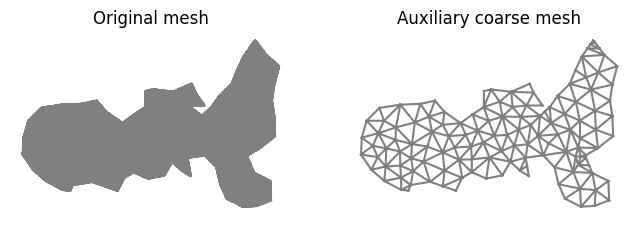

In [87]:
# Plot the two fem spaces
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
fe.plot(mesh)
plt.title("Original mesh")

plt.subplot(1, 2, 2)
fe.plot(coarse_mesh)
plt.title("Auxiliary coarse mesh")

In [88]:
# Config
learning_rate = 1e-3
batch_size = 5
epochs = 500

In [89]:
# Build the dataset
train_size = 800
val_size = 50

dataset = FomDataset(k, pressure, y)
train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

train_loader = DataLoader(train_set, batch_size = batch_size)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader =  DataLoader(test_set, batch_size = batch_size)

<ipython-input-11-67f152691133>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu, dtype=torch.float32)
<ipython-input-11-67f152691133>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(u, dtype=torch.float32)
<ipython-input-11-67f152691133>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [90]:
# Build the model
model = MeshInformedNeuralNetwork(
    dofs=[y, y_coarse, y_coarse, y, y],
    supports=[0.1, 0.4, 0.4, 0.1]
)

model.to(device)
print(model)

MeshInformedNeuralNetwork(
  (mesh_informed_layers): ModuleList(
    (0-3): 4 x MeshInformedLayer(
      (activation_function): LeakyReLU(negative_slope=0.01)
    )
  )
)


In [91]:
def assembleM(V_h):
  """Assembles the L2 mass matrix for P1 elements on a given mesh. Returns an Nh x Nh matrix.
  Matrix action is encoded following the same dofs ordering used in __main__.coordinates."""
  from fenics import assemble, dx, TrialFunction, TestFunction
  from fenics import vertex_to_dof_map
  from IPython.display import clear_output

  V = V_h
  u, v = TrialFunction(V), TestFunction(V) # symbols
  M = assemble(u*v*dx).array()             # bilinear form is assembled and converted to array
  perm = vertex_to_dof_map(V)              # re-sorting to ensure compatibility with mesh ordering
  M = M[perm]
  M = M[:, perm]
  clear_output()
  return torch.tensor(M, device=device, dtype=torch.float32)


In [92]:
# L2 integral loss
def mse_loss(true, predicted):
    diff = true - predicted  # (B, N)

    # Compute (diff @ M @ diff^T) for each sample in the batch
    # Assuming M is (N, N) and diff is (B, N)
    diffM = torch.matmul(diff, M)            # (B, N)
    L2_norm_sq = torch.sum(diffM * diff, dim=1)  # (B,) since diffM * diff is (B, N)

    return L2_norm_sq.mean()


def error_metric(true, predicted):
    diff = true - predicted

    diffM = torch.matmul(diff, M)
    L2_diff_sq = torch.sum(diffM * diff, dim=1)

    trueM = torch.matmul(true, M)
    L2_true_sq = torch.sum(trueM * true, dim=1)

    return (L2_diff_sq / L2_true_sq).mean()


In [93]:
M = assembleM(V_h)

# Define loss function
loss_function = mse_loss
error_metric = error_metric

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [94]:
# Train the model
trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
train_hist, val_hist, test_hist = trainer.fit()

Epoch 1/500:
Current Loss: 2637341.250000  [  705/  750]
Train Loss: 54653208.3208 | Val Loss: 2099455.6250 | Test Loss: 2227483.8469
Epoch 2/500:
Current Loss: 375698.937500  [  705/  750]
Train Loss: 965986.5186 | Val Loss: 350805.3688 | Test Loss: 370780.4109
Epoch 3/500:
Current Loss: 69311.523438  [  705/  750]
Train Loss: 169918.8148 | Val Loss: 68230.0676 | Test Loss: 70700.2306
Epoch 4/500:
Current Loss: 26247.066406  [  705/  750]
Train Loss: 41664.5861 | Val Loss: 28060.9777 | Test Loss: 27907.4395
Epoch 5/500:
Current Loss: 16851.099609  [  705/  750]
Train Loss: 21354.2533 | Val Loss: 19151.3324 | Test Loss: 18960.0212
Epoch 6/500:
Current Loss: 13665.893555  [  705/  750]
Train Loss: 15812.6122 | Val Loss: 15985.9378 | Test Loss: 15745.7978
Epoch 7/500:
Current Loss: 12099.485352  [  705/  750]
Train Loss: 13392.9451 | Val Loss: 14302.1986 | Test Loss: 14137.2829
Epoch 8/500:
Current Loss: 11101.870117  [  705/  750]
Train Loss: 11995.2057 | Val Loss: 13302.9335 | Test Los

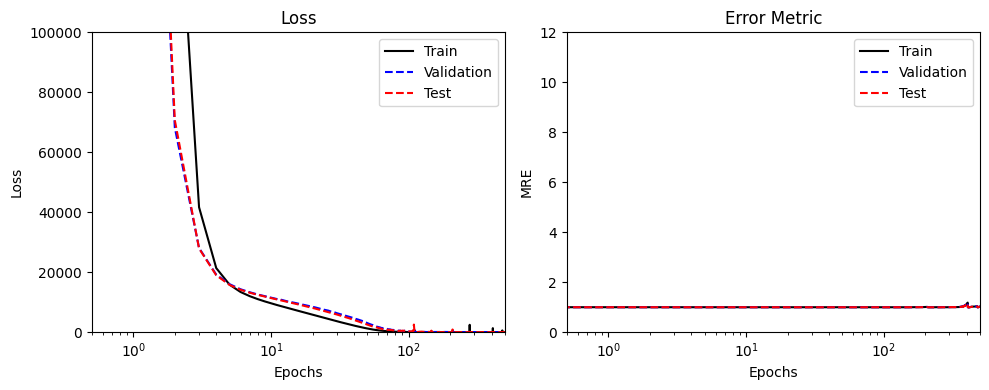

In [95]:
plot_errors(trainer, 100000, 12)

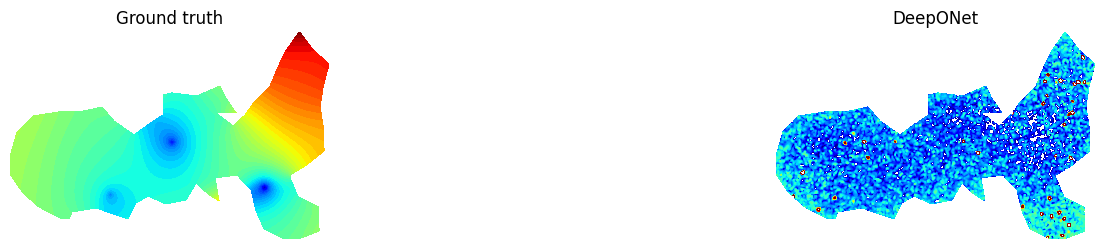

In [96]:
j = -1

test_sample = test_set[j]
k_sens, pressure_test, y = test_sample

vmin, vmax = pressure_test.min(), pressure_test.max()
plt.figure(figsize = (14, 8))
plt.subplot(1, 3, 1)
fe.plot(pressure_test, V_h, levels = 50, vmin = vmin, vmax = vmax)
plt.title("Ground truth")

plt.subplot(1, 3, 3)
mu, true_u, y = add_batch_dimension(test_sample)
fe.plot(model(mu).squeeze(0).detach(), V_h, levels = 50, vmin = vmin, vmax = vmax)
plt.title("DeepONet")
None

In [ ]:
print("MRE for Minns: %s." % num2p(trainer.train_hist['error_metric'][-1]))

## POD-MINNs

In [ ]:
from scipy.linalg import svd

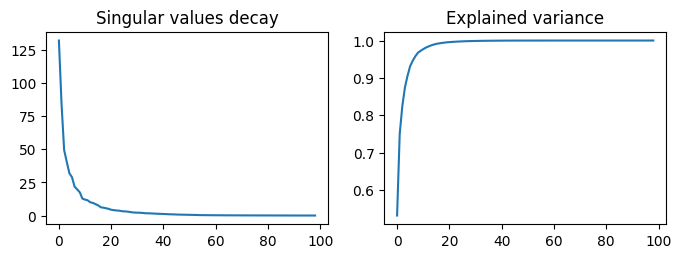

In [ ]:
# Svd
n_train = 800
X, s, _ = svd(pressure[:n_train].T, full_matrices = False)

plt.figure(figsize = (8, 2.5))
plt.subplot(1, 2, 1)
plt.plot(s[1:100])
plt.title("Singular values decay")
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(s[1:100]**2)/np.sum(s[1:]**2))
plt.title("Explained variance")
plt.show()

In [ ]:
# Retain the first n component
n = 15
V = X[:, :n]
V.shape

(9550, 15)

In [ ]:
k, pressure, V = dv.tensor(k, pressure, V)
l2 = L2(V_h)
if(dv == GPU):
  l2.cuda()
clc()

In [ ]:
# Projection error on test set
test_pressure = pressure[n_train:]
projected_pressure = test_pressure @ V @ V.T
mre(l2)(test_pressure, projected_pressure)

tensor(0.0197)

In [ ]:
c = pressure @ V
c.shape

torch.Size([1000, 15])

In [ ]:
class PODMinns(nn.Module):
    def __init__(self, n, input_dof, output_dof):
        super().__init__()
        self.mesh_informed_layers = nn.Sequential(
            MeshInformedLayer(input_dof,output_dof, support=0.1),
            nn.Linear(output_dof.shape[0], 50),
            nn.LeakyReLU(),
            nn.Linear(50, n),
            nn.LeakyReLU(),
        )

    def forward(self, input):
        return self.mesh_informed_layers(input)

In [ ]:
# Config
learning_rate = 1e-3
batch_size = 5
epochs = 600

In [ ]:
# Build the dataset
train_size = n_train
val_size = 50

dataset = FomDataset(k, c, y)
train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

train_loader = DataLoader(train_set, batch_size = batch_size)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader =  DataLoader(test_set, batch_size = batch_size)

<ipython-input-8-67f152691133>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu, dtype=torch.float32)
<ipython-input-8-67f152691133>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(u, dtype=torch.float32)
<ipython-input-8-67f152691133>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [48]:
# Build the model
pod_model = PODMinns(n, y, y_coarse)
pod_model.to(device)
print(pod_model)

NameError: name 'PODMinns' is not defined

In [ ]:
M =  assembleM(V_h)

# Define loss function
loss_function = mse_loss
error_metric = error_metric

# Define optimization strategy
optimizer = torch.optim.Adam(pod_model.parameters(), lr = learning_rate)

In [ ]:
# Train the model
trainer = Trainer(train_loader, val_loader, test_loader, pod_model, loss_function, optimizer, epochs, error_metric)
train_hist, val_hist, test_hist = trainer.fit()

Epoch 1/600:
Current Loss: 8.373644  [  705/  750]
Train Loss: 68.7335 | Val Loss: 11.2245 | Test Loss: 12.8618
Epoch 2/600:
Current Loss: 8.433939  [  705/  750]
Train Loss: 13.3418 | Val Loss: 10.1441 | Test Loss: 12.0213
Epoch 3/600:
Current Loss: 8.212712  [  705/  750]
Train Loss: 12.8779 | Val Loss: 10.0684 | Test Loss: 11.7022
Epoch 4/600:
Current Loss: 7.651416  [  705/  750]
Train Loss: 11.9121 | Val Loss: 9.0430 | Test Loss: 10.5832
Epoch 5/600:
Current Loss: 7.781404  [  705/  750]
Train Loss: 11.4678 | Val Loss: 8.9766 | Test Loss: 10.3590
Epoch 6/600:
Current Loss: 7.032235  [  705/  750]
Train Loss: 10.9338 | Val Loss: 8.8392 | Test Loss: 10.0964
Epoch 7/600:
Current Loss: 6.487920  [  705/  750]
Train Loss: 10.5078 | Val Loss: 7.9513 | Test Loss: 9.0251
Epoch 8/600:
Current Loss: 6.516016  [  705/  750]
Train Loss: 9.6476 | Val Loss: 7.8530 | Test Loss: 8.7433
Epoch 9/600:
Current Loss: 6.667826  [  705/  750]
Train Loss: 9.2660 | Val Loss: 7.7537 | Test Loss: 8.7629
Epo

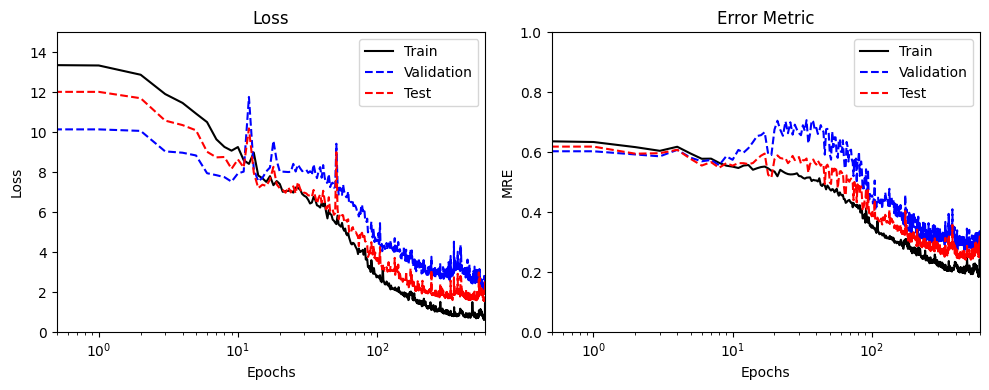

In [ ]:
plot_errors(trainer, 15, 1)

In [ ]:
pod_minn = lambda k_test : pod_model(k_test) @ V.T

In [ ]:
print("MRE for POD-MINN: %s." % num2p(mrei(l2)(pressure[n_train:], pod_minn(k[n_train:]))))

MRE for POD-MINN: 13.35%.


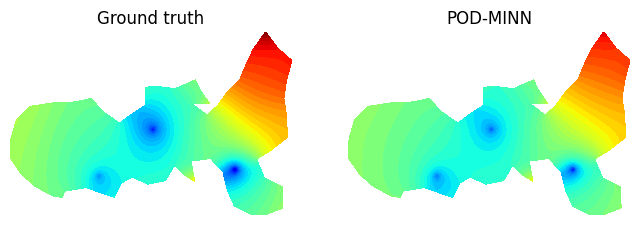

In [ ]:
j = -1
vmin, vmax = pressure[j].min(), pressure[j].max()
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
fe.plot(pressure[j], V_h, levels = 50, vmin = vmin, vmax = vmax)
plt.title("Ground truth")

plt.subplot(1, 2, 2)
fe.plot(pod_minn(k[[j]])[0], V_h, levels = 50, vmin = vmin, vmax = vmax)
plt.title("POD-MINN")
None